# Imports

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix, classification_report
from sklearn.utils.fixes import loguniform

from scipy.stats import randint

from lightgbm import LGBMClassifier

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [4]:
%matplotlib inline
#For autocompletion, please ignore
%config Completer.use_jedi = False

# Data Inspection

In [5]:
train_data_original = pd.read_csv("data/train.csv")
test_data_original = pd.read_csv("data/test.csv")

In [6]:
# Creating a copies of the original datasets
train_data = train_data_original.copy()
test_data = test_data_original.copy()

In [7]:
train_data_original.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [8]:
train_data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [9]:
train_data_original.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [10]:
train_data_original.drop(["CustomerId", "id", "Surname"], axis = 1, inplace = True)
train_data.drop(["CustomerId", "id", "Surname"], axis = 1, inplace = True)
train_data_original

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


In [11]:
m, n = train_data_original.shape
print(f"Number of Rows: {m}")
print(f"Number of Columns: {n}")

Number of Rows: 165034
Number of Columns: 11


### Handling Missing Values 

In [12]:
train_data_original.isnull().any()

CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

No Missing Values So We Can Continue to Data Exploration & Data Visualisation

In [13]:
train_data_original.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [14]:
train_data_original.nunique()

CreditScore          457
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64

# Data Exploration & Visualiation

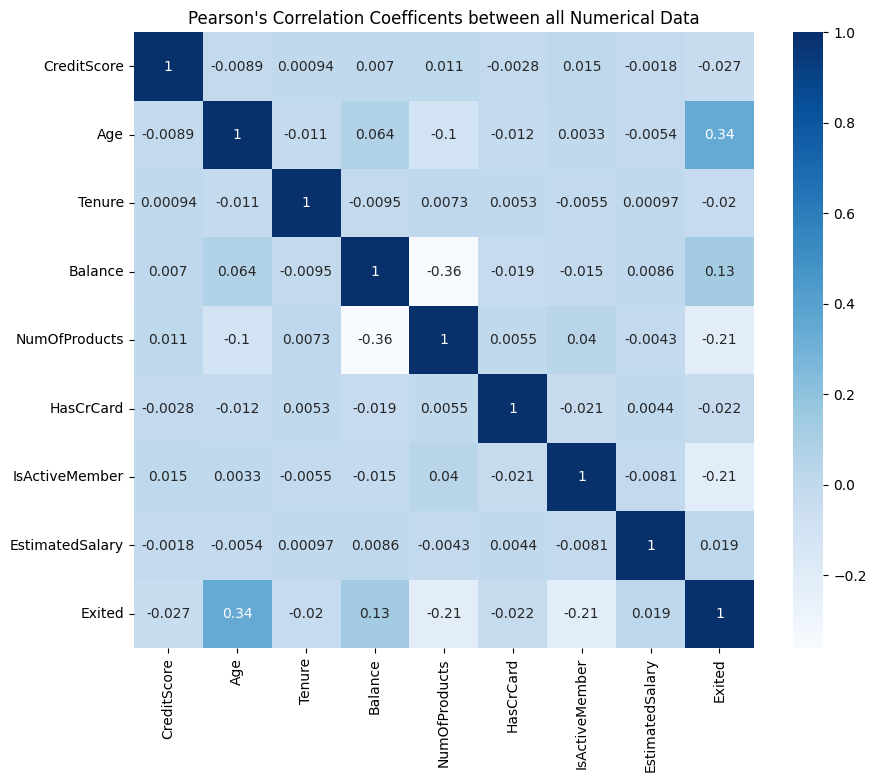

In [15]:
num_cols = [col for col in train_data_original.columns if train_data_original[col].dtype in ["int64", "float64"]]

plt.figure(figsize = (10,8))

sns.heatmap(train_data_original[num_cols].corr(), cmap = "Blues", annot = True)

plt.title("Pearson's Correlation Coefficents between all Numerical Data")
plt.show()

* Positive Correlation for Exiting with Age & Balance
* Negative with Number of Products

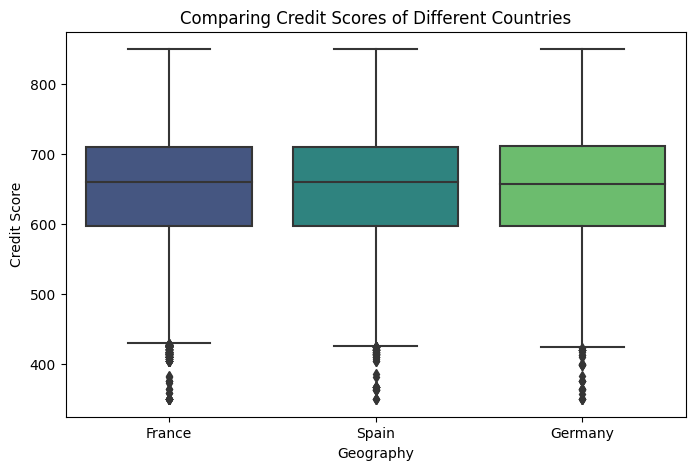

In [16]:
plt.figure(figsize = (8,5))

sns.boxplot(x = "Geography", y = "CreditScore", data = train_data, palette = 'viridis')

plt.title("Comparing Credit Scores of Different Countries")
plt.xlabel("Geography")
plt.ylabel("Credit Score")

plt.show()

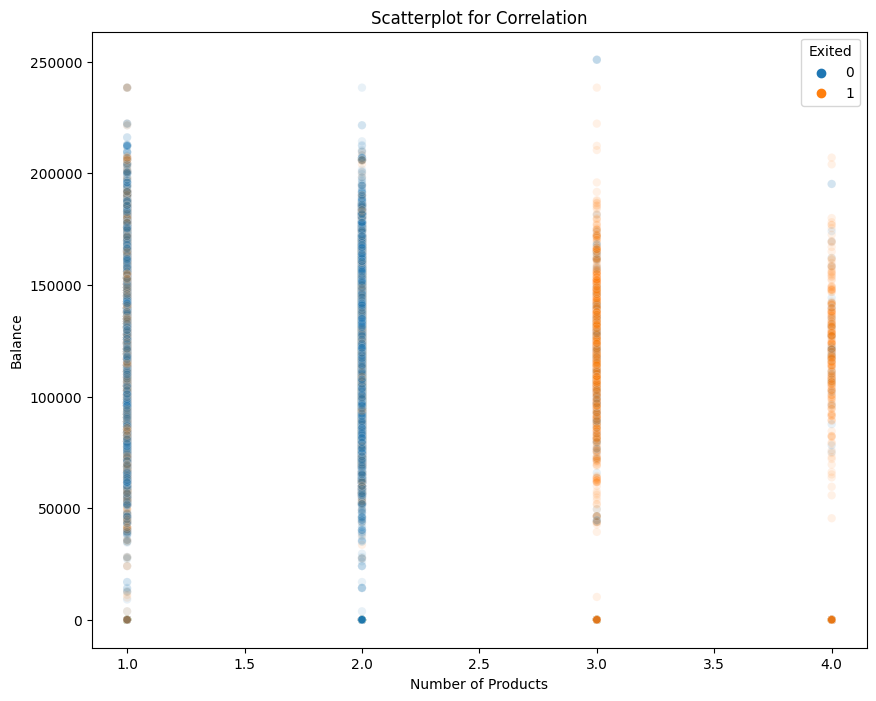

In [17]:
plt.figure(figsize = (10,8))

sns.scatterplot(data=train_data_original, x='NumOfProducts', y='Balance', hue='Exited', alpha=0.1)

plt.title("Scatterplot for Correlation")
plt.xlabel("Number of Products")
plt.ylabel("Balance")

plt.show()

In [18]:
print(f"{train_data_original['NumOfProducts'].value_counts()}")
print("\n")
print(f"{train_data_original['Balance'].value_counts().head()}")


NumOfProducts
2    84291
1    77374
3     2894
4      475
Name: count, dtype: int64


Balance
0.00         89648
124577.33       88
127864.40       64
122314.50       63
129855.32       59
Name: count, dtype: int64


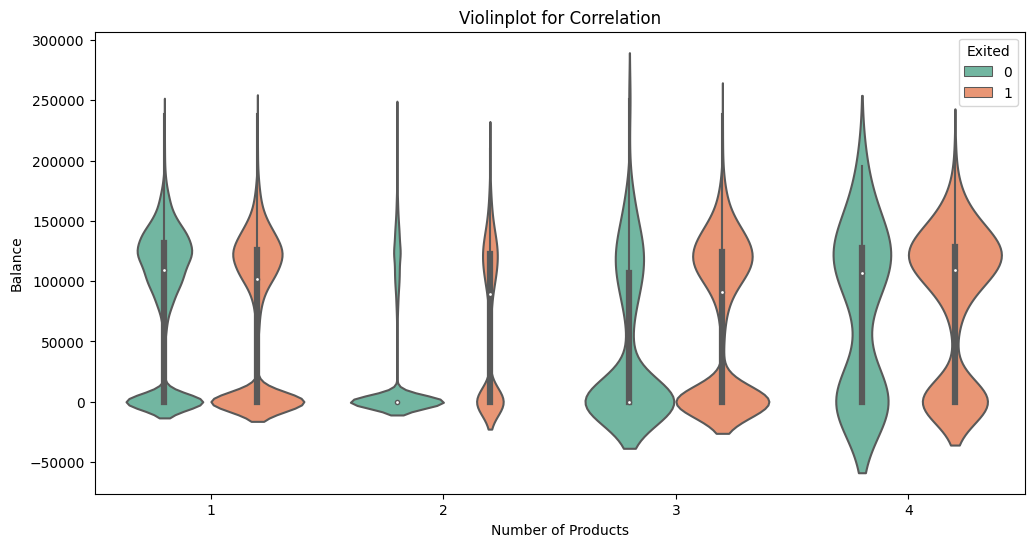

In [19]:
plt.figure(figsize = (12,6))

sns.violinplot(data=train_data_original, x='NumOfProducts', y='Balance', hue='Exited', palette = "Set2")

plt.title("Violinplot for Correlation")
plt.xlabel("Number of Products")
plt.ylabel("Balance")

plt.show()

<Figure size 1400x1400 with 0 Axes>

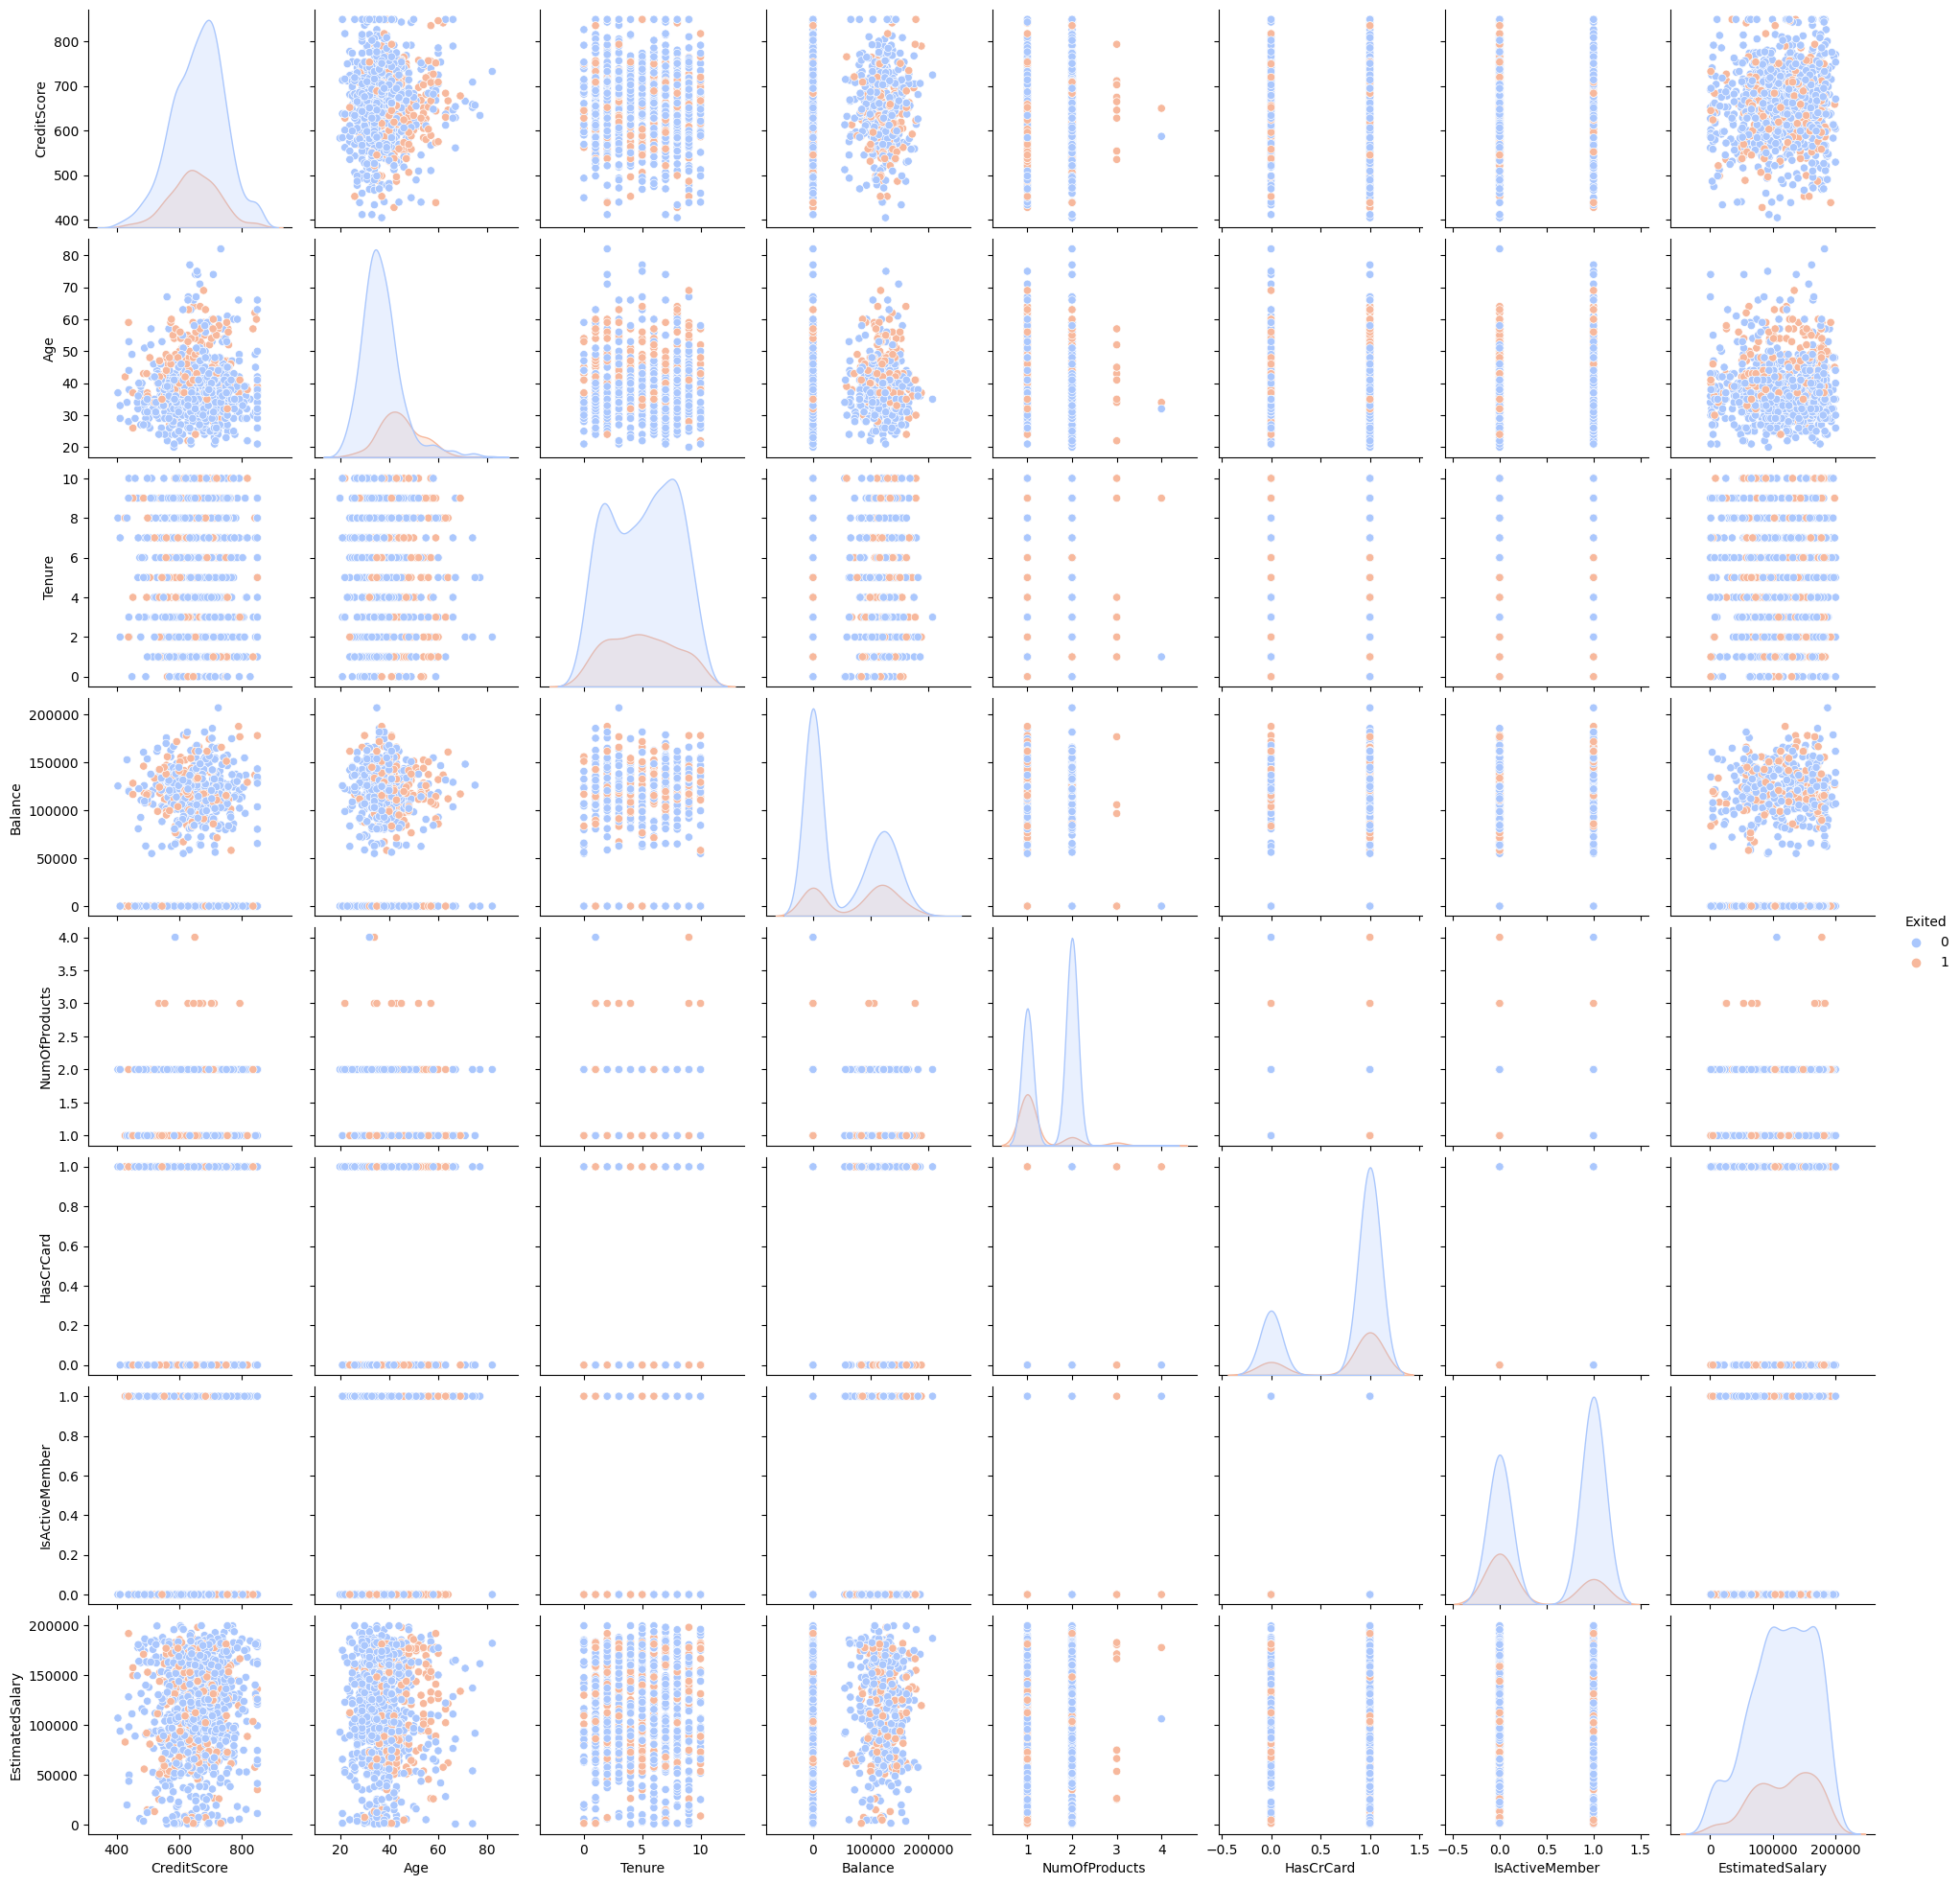

In [20]:
plt.figure(figsize = (14,14))

sns.pairplot(data=train_data_original.sample(1000), hue = 'Exited', palette = 'coolwarm')

plt.show()

# Data Cleaning & Preprocessing

In [21]:
cols_tobe_scaled = ["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary"]
cols_tobe_encoded = [col for col in train_data.columns if train_data[col].nunique() < 6 and train_data[col].dtype == 'object']
cols_left_out = [col for col in train_data.columns if col not in cols_tobe_encoded and col not in cols_tobe_scaled and col != 'Exited']
print(f"The Numerical Columns which are to be normalized are: {cols_tobe_scaled}")
print(f"The Categorical Columns which need to be OneHotEncoded are: {cols_tobe_encoded}")
print(f"Rest Columns are: {cols_left_out}")

The Numerical Columns which are to be normalized are: ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
The Categorical Columns which need to be OneHotEncoded are: ['Geography', 'Gender']
Rest Columns are: ['NumOfProducts', 'HasCrCard', 'IsActiveMember']


In [22]:
train_data[cols_tobe_encoded].apply(lambda col: col.unique())

Geography    [France, Spain, Germany]
Gender                 [Male, Female]
dtype: object

In [23]:
train_data_original.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [24]:
def data_preprocessor(X: pd.DataFrame):
    # 1. Separating Both Targets/Labels & Features

    if (len(X.columns) == 11):
        y_preprocess = X["Exited"]
        X_preprocess = X.drop(['Exited'], axis=1)
    else:
        y_preprocess = 0
        X_preprocess = X
    # 2. Feature Selection
    drop_columns = ["CustomerId", "id", "Surname"]
    if all(col in X_preprocess.columns for col in drop_columns):
        X_preprocess.drop(drop_columns, axis=1, inplace=True)

    # 2. What are the NUMERICAL & CATEGORICAL columns
    print(f"The Numerical Columns which are to be normalized are: {cols_tobe_scaled}")
    print(f"The Categorical Columns which need to be One Hot Encoded are: {cols_tobe_encoded}")
    print(f"Rest Columns are: {cols_left_out}")

    # 3. Transforming Numerical Columns
    s_scaler = StandardScaler()

    X_preprocess_1 = X_preprocess[cols_left_out]
    X_preprocess_1 = pd.concat([X_preprocess_1, X_preprocess[cols_tobe_encoded]], axis = 1)

    X_tobe_scaled = X_preprocess[cols_tobe_scaled]
    X_tobe_scaled = pd.DataFrame(s_scaler.fit_transform(X_tobe_scaled), columns = cols_tobe_scaled)

    X_preprocess = pd.concat([X_tobe_scaled, X_preprocess_1], axis = 1)

    # 4. Transforming Categorical Columns
    OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)
    OH_df = pd.DataFrame(OH_encoder.fit_transform(X_preprocess[cols_tobe_encoded]))

    OH_df.index = X_preprocess.index
    num_df = X_preprocess.drop(cols_tobe_encoded, axis = 1)

    X_preprocess = pd.concat([num_df, OH_df], axis = 1)
    X_preprocess.columns = X_preprocess.columns.astype(str)

    return X_preprocess, y_preprocess
    
    

In [25]:
Xp, yp = data_preprocessor(train_data)
Xp.head()

The Numerical Columns which are to be normalized are: ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
The Categorical Columns which need to be One Hot Encoded are: ['Geography', 'Gender']
Rest Columns are: ['NumOfProducts', 'HasCrCard', 'IsActiveMember']


,CreditScore,Age,Tenure,Balance,EstimatedSalary,NumOfProducts,HasCrCard,IsActiveMember,0,1,2,3,4
0,0.144135,-0.578074,-0.719973,-0.883163,1.369486,2,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.367706,-0.578074,-1.432694,-0.883163,-1.254085,2,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.268974,0.211354,1.774548,-0.883163,1.437422,2,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,-0.941966,-0.465299,-1.076334,1.486918,-0.557018,1,1.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.743362,-0.578074,-0.007253,-0.883163,-1.938770,2,1.0,1.0,0.0,0.0,1.0,0.0,1.0


In [26]:
yp.head()

0    0
1    0
2    0
3    0
4    0
Name: Exited, dtype: int64

In [27]:
Xp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  float64
 1   Age              165034 non-null  float64
 2   Tenure           165034 non-null  float64
 3   Balance          165034 non-null  float64
 4   EstimatedSalary  165034 non-null  float64
 5   NumOfProducts    165034 non-null  int64  
 6   HasCrCard        165034 non-null  float64
 7   IsActiveMember   165034 non-null  float64
 8   0                165034 non-null  float64
 9   1                165034 non-null  float64
 10  2                165034 non-null  float64
 11  3                165034 non-null  float64
 12  4                165034 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 16.4 MB


In [28]:
Xp['NumOfProducts'] = Xp['NumOfProducts'].astype(float)

In [29]:
input_features = Xp.shape[1]

In [30]:
# Splitting the data into training & test splits
X_train, X_test, y_train, y_test = train_test_split(Xp, yp,
                                                    test_size  = 0.2, # 20% of data is test & 80% is train
                                                    random_state = 42,
                                                    shuffle = True)

# Neural Network

### 1. Building the Model

In [31]:
torch.manual_seed(42)

In [32]:
# Device Agnostic Code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [33]:
# Conversion to PyTorch tensors
X_train= torch.tensor(X_train.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float)

X_test= torch.tensor(X_test.values, dtype=torch.float)
y_test= torch.tensor(y_test.values, dtype=torch.float)

In [34]:
# my first pytorch model
class My_ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                            nn.Linear(in_features = input_features, out_features = 64),
                            nn.ReLU(),
                            nn.Linear(in_features = 64 , out_features = 64),
                            nn.ReLU(),
                            nn.Linear(in_features = 64 , out_features = 32),
                            nn.ReLU(),
                            nn.Linear(in_features = 32, out_features = 1))
    
    def forward(self, x):
        return self.layers(x)
        

In [35]:
my_model = My_ANN().to('cuda')
my_model

My_ANN(
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [36]:
next(my_model.parameters()).device

device(type='cuda', index=0)

In [37]:
# Loss Function & Optimizer

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params = my_model.parameters(),
                            lr = 0.1)

### Training the Model

In [38]:
# Training & Testing Loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 500

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 0. Training Mode
    my_model.train()

    # 1. Forward Propagation
    y_logits = my_model(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. Calculating Loss
    loss = loss_fn(y_logits,
                   y_train) # Without logitsloss we expect probabilities, nn.BCEWithLogitsLoss() expects raw logits
    ROC = roc_auc_score(y_true = y_train.cpu().detach().numpy(),
                  y_score = y_preds.cpu().detach().numpy())

    # 3. Optimizer Zero Grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer Step
    optimizer.step()

    ## Testing
    my_model.eval()
    with torch.inference_mode():
        # 1. Forward Pass
        test_logits = my_model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate Loss
        test_loss = loss_fn(test_logits,
                            y_test)
        test_roc = roc_auc_score(y_true = y_test.cpu().numpy(),
                      y_score = test_pred.cpu().numpy())

    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train ROC: {ROC:.3f} | Test loss: {test_loss:.5f} | Test ROC: {test_roc:.2f}")


Epoch: 0 | Train Loss: 0.65692 | Train ROC: 0.500 | Test loss: 3.88278 | Test ROC: 0.50
Epoch: 20 | Train Loss: 0.51639 | Train ROC: 0.500 | Test loss: 0.51525 | Test ROC: 0.50
Epoch: 40 | Train Loss: 0.51633 | Train ROC: 0.500 | Test loss: 0.51493 | Test ROC: 0.50
Epoch: 60 | Train Loss: 0.51606 | Train ROC: 0.501 | Test loss: 0.51488 | Test ROC: 0.50
Epoch: 80 | Train Loss: 0.47595 | Train ROC: 0.564 | Test loss: 0.46881 | Test ROC: 0.60
Epoch: 100 | Train Loss: 0.38326 | Train ROC: 0.712 | Test loss: 0.38105 | Test ROC: 0.67
Epoch: 120 | Train Loss: 0.39324 | Train ROC: 0.670 | Test loss: 0.37351 | Test ROC: 0.70
Epoch: 140 | Train Loss: 0.35059 | Train ROC: 0.730 | Test loss: 0.35200 | Test ROC: 0.74
Epoch: 160 | Train Loss: 0.34323 | Train ROC: 0.726 | Test loss: 0.34344 | Test ROC: 0.74
Epoch: 180 | Train Loss: 0.33994 | Train ROC: 0.733 | Test loss: 0.34042 | Test ROC: 0.73
Epoch: 200 | Train Loss: 0.33833 | Train ROC: 0.731 | Test loss: 0.33913 | Test ROC: 0.73
Epoch: 220 | Tra

-----neural network still in works, will be tuned and updated later on-----

# LGBM Model 

### Hyperparameter Tuning

In [39]:
param_grid = {
    'n_estimators': randint(5, 1000),            
    'learning_rate': loguniform(1e-3, 0.1),     
    'max_depth': randint(2, 50),                 
    'num_leaves': randint(2, 50),                
    'min_child_samples': randint(2,50 ),         
    'subsample': loguniform(0.1, 1.0),           
    'subsample_freq': randint(1, 10)}

model = LGBMClassifier(random_state=2401)

randomsearch = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy')
randomsearch.fit(X_train.cpu().numpy(), y_train.cpu().numpy())

print("The Best Hyperparameters are: ", randomsearch.best_params_)
print("Best Score: ", randomsearch.best_score_)

The Best Hyperparameters are:  {'learning_rate': 0.02395856782141658, 'max_depth': 22, 'min_child_samples': 44, 'n_estimators': 958, 'num_leaves': 17, 'subsample': 0.3829476017913003, 'subsample_freq': 5}
Best Score:  0.8650806520119321


### Building the Model

In [40]:
model = LGBMClassifier(random_state = 2401, n_estimators = 135, learning_rate = 0.08920, 
                             max_depth = 29, num_leaves = 38, min_child_samples = 20, 
                             subsample = 0.9042338683390199, subsample_freq = 6)
model.fit(X_train.cpu().numpy(), y_train.cpu().numpy())

pred = model.predict_proba(X_test.cpu().numpy())[:, 1] 
pred_label = np.where(pred > 0.5, 1, 0)

### Metrics

In [41]:
print(f"Confusion Matrix: \n{confusion_matrix(y_test.cpu().numpy(), pred_label)}")
print(f"Classification Report: \n{classification_report(y_test.cpu().numpy(), pred_label)}")

Confusion Matrix: 
[[24686  1366]
 [ 3009  3946]]
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92     26052
         1.0       0.74      0.57      0.64      6955

    accuracy                           0.87     33007
   macro avg       0.82      0.76      0.78     33007
weighted avg       0.86      0.87      0.86     33007



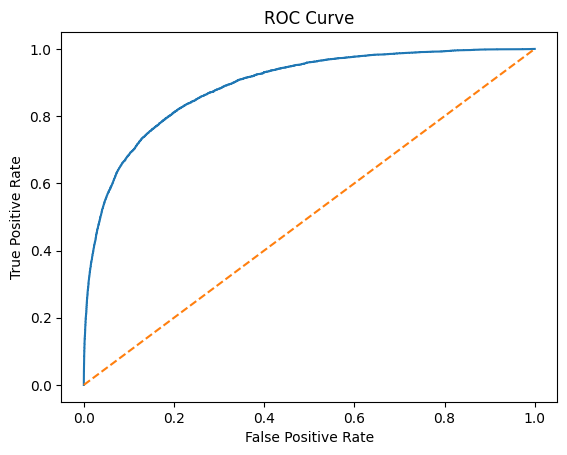

0.8910832016219731

In [42]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test.cpu().numpy(), pred)

plt.title("ROC Curve")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0,1], ls = '--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

roc_auc_score(y_test.cpu().numpy(), pred)

LGBMClassifier() has a higher roc_auc-score so we will utilize it

# Test Prediction & Submission

### Preprocessing of Test Data 

In [43]:
test = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")

In [44]:
indexes = test["id"]

In [45]:
test, p = data_preprocessor(test)

The Numerical Columns which are to be normalized are: ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
The Categorical Columns which need to be One Hot Encoded are: ['Geography', 'Gender']
Rest Columns are: ['NumOfProducts', 'HasCrCard', 'IsActiveMember']


In [46]:
test.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,NumOfProducts,HasCrCard,IsActiveMember,0,1,2,3,4
0,-0.878176,-1.706504,-1.067887,-0.881274,0.967874,2,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,0.329567,0.888990,-1.067887,-0.881274,-0.790939,1,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.006609,-0.465181,0.713922,-0.881274,0.528413,2,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.304665,-0.239486,1.070284,-0.881274,0.032150,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.188684,-0.013791,1.783008,1.050038,0.539331,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0


### Evaluation

In [47]:
predictions = model.predict_proba(test)[:, 1] 

### Submission

In [48]:
output = pd.DataFrame({'id': indexes,
                       'Exited': predictions})
print(output.shape)
output.head()

(110023, 2)


,id,Exited
0,165034,0.026748
1,165035,0.812649
2,165036,0.027769
3,165037,0.229032
4,165038,0.315487


In [49]:
output.to_csv('submission.csv', index=False)